To compare ETFs we need a few imports.

In [1]:
import yahooquery as yq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Because we want to compare a growth ETF like ARKK, in which not every stock has earnings, with a broader marketcap indice like VWCE and a theme technlogy ETF, XDWT, we need to compare there revenue, revenue growth, profit margin and gross profit margin.

In [2]:

from scipy import stats

def generateAverageGrowthAndMargin(ticker:str, fund:dict = None, symbolsAndHoldingPercent:dict = None) -> tuple:

    if fund:
        df = pd.DataFrame(fund.fund_holding_info[ticker]['holdings'])
        symbolsAndHoldingPercent = df[["symbol", "holdingPercent"]]

    revenuePerSharePrices: list = []
    revenueGrowths: list = []
    profitMargins: list = []
    holdingPercents: list = []
    grossMargins: list = []
    priceToSaless: list = []
    profit_growth_projectionss = []
    gross_growth_projectionss = []

    highest = None

    for row in symbolsAndHoldingPercent.iterrows():
        try:
            symbol = row[1].values[0]
            # print(symbol)
            holdingPercent = row[1].values[1]
            holdingPercents.append(holdingPercent)
            
            fund = yq.Ticker(symbol)
            
            # filter companies 
            #if symbol == "TSLA" or symbol == "COIN" or symbol == "ROKU" or symbol == "TDOC":
            #continue

            price = fund.financial_data[symbol]["currentPrice"]
            revenueGrowth = fund.financial_data[symbol]["revenueGrowth"]
            revenuePerShare = fund.financial_data[symbol]["revenuePerShare"]
            profitMargin = fund.financial_data[symbol]["profitMargins"]
            revenuePerSharePrice = round(revenuePerShare / price,2)
            priceToSales = round(price / revenuePerShare)
            grossMargin = fund.financial_data[symbol]["grossMargins"]

            revenueGrowths.append(revenueGrowth * holdingPercent)
            revenuePerSharePrices.append(revenuePerSharePrice * holdingPercent)
            profitMargins.append(profitMargin * holdingPercent)
            grossMargins.append(grossMargin * holdingPercent)
            priceToSaless.append(priceToSales * holdingPercent)

            profit_growth_projections = projectFutureGrowth(revenuePerSharePrice, revenueGrowth, profitMargin)
            profit_growth_projectionss.append(profit_growth_projections * holdingPercent)

            gross_growth_projections = projectFutureGrowth(revenuePerSharePrice, revenueGrowth, grossMargin)

            # just to find the companies with the highest growth projections. 
            if highest is None or gross_growth_projections[0]> highest:
                #print(highest)
                highest = gross_growth_projections[0]
                #print(symbol)
            gross_growth_projectionss.append(gross_growth_projections)
        except Exception:
            print(Exception)
            continue


    profit_growth_projectionss = pd.DataFrame(profit_growth_projectionss)
    sum_of_each_year_profit_projection = profit_growth_projectionss.sum(axis=0)

    gross_growth_projectionss = pd.DataFrame(gross_growth_projectionss)
    sum_of_each_year_gross_projection = gross_growth_projectionss.sum(axis=0)
    
    
    sumHoldingPercents = sum(holdingPercents)
    
    weigted_profit_projections_for_each_year = sum_of_each_year_profit_projection.values / sumHoldingPercents
    weigted_gross_projections_for_each_year = sum_of_each_year_gross_projection.values / sumHoldingPercents

    meanRevenueGrowth = sum(revenueGrowths) / sumHoldingPercents
    meanRevenuePerSharePrices = sum(revenuePerSharePrices) / sumHoldingPercents
    meanProfitMargins = sum(profitMargins) / sumHoldingPercents
    meanGrossMargins = sum(grossMargins) / sumHoldingPercents
    mean_price_to_sales = sum(priceToSaless) / sumHoldingPercents
   
    print(ticker, " top 10 average meanRevenuePerSharePrices", meanRevenuePerSharePrices, "meanRevenueGrowth", meanRevenueGrowth,
          "profitMargins", meanProfitMargins, "meanGrossMargins", meanGrossMargins, "holdingsPercentSum", "sumHoldingPercents", sumHoldingPercents, "mean_price_to_sales", mean_price_to_sales)
    return meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins, meanGrossMargins, weigted_profit_projections_for_each_year, weigted_gross_projections_for_each_year

Now we need a function that projects the earning/ revenue growth into the future.

In [3]:
def projectFutureGrowth(meanRevenuePerShare, meanRevenueGrowth, meanGrossOrProfitMargin, years= 5):
    
    base = meanRevenuePerShare * meanGrossOrProfitMargin
    bases = []
    bases.append(base)
    for i in range(1, years+1):
        base = base * (1 + meanRevenueGrowth)
        bases.append(base)

    return np.array(bases)

We plot the future earnings growth, by taking the current profit margin of each stock in these ETFs into account.
Which is not the fairest way to compare with ARKK because they invest into development of the company and therefore have a lower profit margin.

ARKK  top 10 average meanRevenuePerSharePrices 0.2995284560801109 meanRevenueGrowth 0.19315548767588112 profitMargins -0.1063155794366936 meanGrossMargins 0.5101156163921402 holdingsPercentSum sumHoldingPercents 0.4920000030000001 mean_price_to_sales 5.0221544531169435
BRK-A  top 10 average meanRevenuePerSharePrices 0.43 meanRevenueGrowth 0.09 profitMargins -0.00452 meanGrossMargins -0.0030399999 holdingsPercentSum sumHoldingPercents 100 mean_price_to_sales 2.0
XDWT  top 10 average meanRevenuePerSharePrices 0.14404672057502244 meanRevenueGrowth 0.10030008984725965 profitMargins 0.28993095090386345 meanGrossMargins 0.6141233555867026 holdingsPercentSum sumHoldingPercents 55.650000000000006 mean_price_to_sales 8.384186882300087
VWCE  top 10 average meanRevenuePerSharePrices 0.22747972972972977 meanRevenueGrowth 0.12230270270270271 profitMargins 0.24026919624594598 meanGrossMargins 0.5198526005135136 holdingsPercentSum sumHoldingPercents 14.799999999999999 mean_price_to_sales 5.9020270270

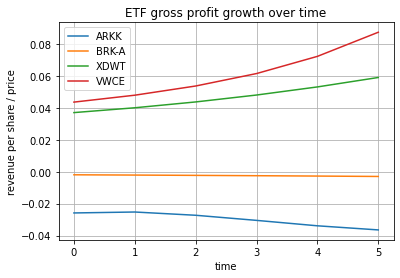

In [4]:

legend = []

ticker = "ARKK"
legend.append(ticker)
fund = yq.Ticker(ticker)
meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins, meanGrossMargins, weigted_profit_projections_for_each_year, weigted_gross_projections_for_each_year  = generateAverageGrowthAndMargin(ticker, fund)
mean_weigthed_profit_growth = projectFutureGrowth(meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins)
#plt.plot(mean_weigthed_profit_growth)
plt.plot(weigted_profit_projections_for_each_year)


ticker = "BRK-A"
legend.append(ticker)
tickers_and_holdings = [[ticker,100]]
meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins, meanGrossMargins, weigted_profit_projections_for_each_year, weigted_gross_projections_for_each_year  = generateAverageGrowthAndMargin(ticker, symbolsAndHoldingPercent= pd.DataFrame(tickers_and_holdings, columns=["symbol","holdingPercent"]))
mean_weigthed_profit_growth = projectFutureGrowth(meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins)
#plt.plot(mean_weigthed_profit_growth)
plt.plot(weigted_profit_projections_for_each_year)

ticker = "XDWT"
legend.append(ticker)
tickers_and_holdings = [["AAPL",17.96],["MSFT",15.16],["NVDA",3.87],["V",3.1],["MA",2.53],["AVGO",2.53],["PYPL",2.53],["ASML",2.25],["ADBE",2.19],["INTC",1.78],["CRM",1.75]]
meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins, meanGrossMargins, weigted_profit_projections_for_each_year, weigted_gross_projections_for_each_year = generateAverageGrowthAndMargin(ticker, symbolsAndHoldingPercent= pd.DataFrame(tickers_and_holdings, columns=["symbol","holdingPercent"]))
mean_weigthed_profit_growth = projectFutureGrowth(meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins)
#plt.plot(mean_weigthed_profit_growth)
plt.plot(weigted_profit_projections_for_each_year)


ticker = "VWCE"
legend.append(ticker)
tickers_and_holdings = [["AAPL",3.2],["MSFT",3.04],["AMZN",2.22],["META",1.24],["GOOG",1.14],["GOOGL",1.01],["TSLA",0.79],["2330.TW",0.76],["NVDA",0.71],["JPM",0.69]]
meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins, meanGrossMargins, weigted_profit_projections_for_each_year, weigted_gross_projections_for_each_year  = generateAverageGrowthAndMargin(ticker, symbolsAndHoldingPercent= pd.DataFrame(tickers_and_holdings, columns=["symbol","holdingPercent"]))
mean_weigthed_profit_growth = projectFutureGrowth(meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins)
#plt.plot(mean_weigthed_profit_growth)
plt.plot(weigted_profit_projections_for_each_year)


plt.title("ETF gross profit growth over time")
plt.legend(legend)
plt.grid()
plt.ylabel("revenue per share / price")
plt.xlabel("time")
plt.show()

Now lets compare future revenue growth by with taking the gross margin into account. 
Because ARKK is a growth ETF in wich the companies are redeploying there profit into research and development.

ARKK  top 10 average meanRevenuePerSharePrices 0.2995284560801109 meanRevenueGrowth 0.19315548767588112 profitMargins -0.1063155794366936 meanGrossMargins 0.5101156163921402 holdingsPercentSum sumHoldingPercents 0.4920000030000001 mean_price_to_sales 5.0221544531169435
BRK-A  top 10 average meanRevenuePerSharePrices 0.43 meanRevenueGrowth 0.09 profitMargins -0.00452 meanGrossMargins -0.0030399999 holdingsPercentSum sumHoldingPercents 100 mean_price_to_sales 2.0
XDWT  top 10 average meanRevenuePerSharePrices 0.14404672057502244 meanRevenueGrowth 0.10030008984725965 profitMargins 0.28993095090386345 meanGrossMargins 0.6141233555867026 holdingsPercentSum sumHoldingPercents 55.650000000000006 mean_price_to_sales 8.384186882300087
VWCE  top 10 average meanRevenuePerSharePrices 0.25690989496959654 meanRevenueGrowth 0.14308568269762303 profitMargins 0.2201083635688226 meanGrossMargins 0.47516606426550595 holdingsPercentSum sumHoldingPercents 18.089999999999996 mean_price_to_sales 5.6440022111

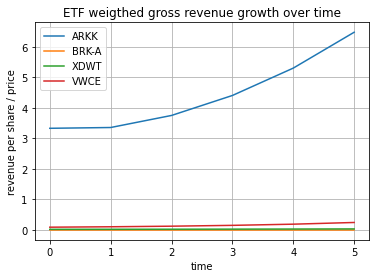

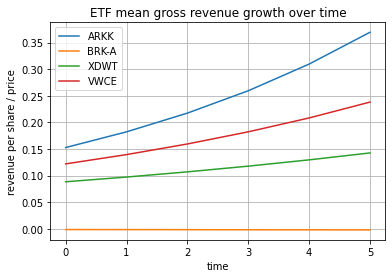

In [5]:
legend = []

ticker = "ARKK"
legend.append(ticker)
fund = yq.Ticker(ticker)
meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins, meanGrossMargins, weigted_profit_projections_for_each_year, weigted_gross_projections_for_each_year = generateAverageGrowthAndMargin(ticker, fund)
bases_arkk = projectFutureGrowth(meanRevenuePerSharePrices, meanRevenueGrowth, meanGrossMargins)
#plt.plot(bases)
plt.plot(weigted_gross_projections_for_each_year)

ticker = "BRK-A"
legend.append(ticker)
tickers_and_holdings = [[ticker,100]]
meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins, meanGrossMargins, weigted_profit_projections_for_each_year, weigted_gross_projections_for_each_year = generateAverageGrowthAndMargin(ticker, symbolsAndHoldingPercent= pd.DataFrame(tickers_and_holdings, columns=["symbol","holdingPercent"]))
bases_brka = projectFutureGrowth(meanRevenuePerSharePrices, meanRevenueGrowth, meanGrossMargins)
#plt.plot(bases)
plt.plot(weigted_gross_projections_for_each_year)

ticker = "XDWT"
legend.append(ticker)
tickers_and_holdings = [["AAPL",17.96],["MSFT",15.16],["NVDA",3.87],["V",3.1],["MA",2.53],["AVGO",2.53],["PYPL",2.53],["ASML",2.25],["ADBE",2.19],["INTC",1.78],["CRM",1.75]]
meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins, meanGrossMargins, weigted_profit_projections_for_each_year, weigted_gross_projections_for_each_year = generateAverageGrowthAndMargin(ticker, symbolsAndHoldingPercent= pd.DataFrame(tickers_and_holdings, columns=["symbol","holdingPercent"]))
bases_xdwt = projectFutureGrowth(meanRevenuePerSharePrices, meanRevenueGrowth, meanGrossMargins)
#plt.plot(bases)
plt.plot(weigted_gross_projections_for_each_year)

ticker = "VWCE"
legend.append(ticker)
tickers_and_holdings = [["AAPL",4.11],["MSFT",3.34],["AMZN",1.93],["TSLA",1.2],["GOOG",1.11],["GOOGL",1.03],["UNH",0.83],["JNJ",0.72],["XOM",0.69],["TSM",0.68]
,["META",0.64],["BRK-A",0.63],["NVDA",0.62],["JPM",0.56]]
meanRevenuePerSharePrices, meanRevenueGrowth, meanProfitMargins, meanGrossMargins, weigted_profit_projections_for_each_year, weigted_gross_projections_for_each_year = generateAverageGrowthAndMargin(ticker, symbolsAndHoldingPercent= pd.DataFrame(tickers_and_holdings, columns=["symbol","holdingPercent"]))
bases_vwce = projectFutureGrowth(meanRevenuePerSharePrices, meanRevenueGrowth, meanGrossMargins)
#plt.plot(bases)
plt.plot(weigted_gross_projections_for_each_year)

plt.title("ETF weigthed gross revenue growth over time")
plt.legend(legend)
plt.grid()
plt.ylabel("revenue per share / price")
plt.xlabel("time")
plt.show()

plt.title("ETF mean gross revenue growth over time")
plt.plot(bases_arkk)
plt.plot(bases_brka)
plt.plot(bases_xdwt)
plt.plot(bases_vwce)
plt.legend(legend)
plt.grid()
plt.ylabel("revenue per share / price")
plt.xlabel("time")
plt.show()



Arkk outperforms right now.